# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv2d_202', 'block8_10_conv', 'conv_7b']
    LAST_LAYER = 'conv_7b'
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ],
    class_weight=class_weights
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 2.0451 - accuracy: 0.3970

947/947 [==============================] - 3667s 4s/step - loss: 2.0451 - accuracy: 0.3970 - val_loss: 5.0738 - val_accuracy: 0.6734
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 1.8770 - accuracy: 0.4688

947/947 [==============================] - 3347s 4s/step - loss: 1.8770 - accuracy: 0.4688 - val_loss: 1.2478 - val_accuracy: 0.5806
Epoch 3/200
947/947 [==============================] - 3180s 3s/step - loss: 1.7431 - accuracy: 0.4910 - val_loss: 1.7168 - val_accuracy: 0.3941
Epoch 4/200
947/947 [==============================] - 3169s 3s/step - loss: 1.7081 - accuracy: 0.4958 - val_loss: 1.7067 - val_accuracy: 0.4632
Epoch 5/200
947/947 [==============================] - 3079s 3s/step - loss: 1.6083 - accuracy: 0.5107 - val_loss: 2.1271 - val_accuracy: 0.5117
Epoch 6/200
947/947 [==============================] - 3055s 3s/step - loss: 1.5932 - accuracy: 0.5258 - val_loss: 1.4940 - val_accuracy: 0.4688
Epoch 7/200
947/947 [==============================] - 3061s 3s/step - loss: 1.5386 - accuracy: 0.5324 - val_loss: 3.3900 - val_accuracy: 0.1463
Epoch 8/200
947/947 [==============================] - 2903s 3s/step - loss: 1.5400 - accuracy: 0.5442 - val_loss: 8.5432 - val_accuracy: 0.27

947/947 [==============================] - 3060s 3s/step - loss: 1.4827 - accuracy: 0.5595 - val_loss: 1.0478 - val_accuracy: 0.6279
Epoch 10/200
947/947 [==============================] - 3071s 3s/step - loss: 1.4565 - accuracy: 0.5566 - val_loss: 1.2140 - val_accuracy: 0.5882
Epoch 11/200
947/947 [==============================] - 3001s 3s/step - loss: 1.3870 - accuracy: 0.5668 - val_loss: 1.2726 - val_accuracy: 0.5524
Epoch 12/200
947/947 [==============================] - 2916s 3s/step - loss: 1.3486 - accuracy: 0.5809 - val_loss: 1.4214 - val_accuracy: 0.5740
Epoch 13/200
947/947 [==============================] - 2950s 3s/step - loss: 1.3066 - accuracy: 0.5857 - val_loss: 1.7520 - val_accuracy: 0.6391
Epoch 14/200
947/947 [==============================] - 3037s 3s/step - loss: 1.2818 - accuracy: 0.5935 - val_loss: 2.2428 - val_accuracy: 0.5985
Epoch 15/200
947/947 [==============================] - 2965s 3s/step - loss: 1.2713 - accuracy: 0.5956 - val_loss: 1.1397 - val_accuracy

947/947 [==============================] - 3016s 3s/step - loss: 1.1541 - accuracy: 0.6208 - val_loss: 1.0329 - val_accuracy: 0.6418
Epoch 21/200
947/947 [==============================] - 2791s 3s/step - loss: 1.1256 - accuracy: 0.6122 - val_loss: 1.0756 - val_accuracy: 0.6294
Epoch 22/200
947/947 [==============================] - 2700s 3s/step - loss: 1.0679 - accuracy: 0.6338 - val_loss: 1.1353 - val_accuracy: 0.6018
Epoch 23/200
947/947 [==============================] - ETA: 0s - loss: 1.0579 - accuracy: 0.6304

947/947 [==============================] - 2849s 3s/step - loss: 1.0579 - accuracy: 0.6304 - val_loss: 0.9780 - val_accuracy: 0.6409
Epoch 24/200
947/947 [==============================] - ETA: 0s - loss: 1.0480 - accuracy: 0.6302

947/947 [==============================] - 2814s 3s/step - loss: 1.0480 - accuracy: 0.6302 - val_loss: 0.9161 - val_accuracy: 0.6563
Epoch 25/200
947/947 [==============================] - 2745s 3s/step - loss: 1.0005 - accuracy: 0.6438 - val_loss: 1.1450 - val_accuracy: 0.5612
Epoch 26/200
947/947 [==============================] - ETA: 0s - loss: 0.9730 - accuracy: 0.6471

947/947 [==============================] - 3053s 3s/step - loss: 0.9730 - accuracy: 0.6471 - val_loss: 0.8766 - val_accuracy: 0.6851
Epoch 27/200
947/947 [==============================] - 2579s 3s/step - loss: 0.9831 - accuracy: 0.6380 - val_loss: 0.9419 - val_accuracy: 0.6608
Epoch 28/200
947/947 [==============================] - 2783s 3s/step - loss: 0.9453 - accuracy: 0.6490 - val_loss: 1.1008 - val_accuracy: 0.5989
Epoch 29/200
947/947 [==============================] - 2836s 3s/step - loss: 1.0200 - accuracy: 0.6287 - val_loss: 1.0123 - val_accuracy: 0.6320
Epoch 30/200
947/947 [==============================] - 2648s 3s/step - loss: 0.9048 - accuracy: 0.6567 - val_loss: 1.1418 - val_accuracy: 0.5785
Epoch 31/200
947/947 [==============================] - 2728s 3s/step - loss: 0.9141 - accuracy: 0.6528 - val_loss: 0.9672 - val_accuracy: 0.6304
Epoch 32/200
947/947 [==============================] - 2695s 3s/step - loss: 0.9226 - accuracy: 0.6525 - val_loss: 0.9236 - val_accuracy

947/947 [==============================] - 2840s 3s/step - loss: 0.8761 - accuracy: 0.6610 - val_loss: 0.7344 - val_accuracy: 0.7177
Epoch 36/200
947/947 [==============================] - 2529s 3s/step - loss: 0.8269 - accuracy: 0.6754 - val_loss: 8.5779 - val_accuracy: 0.6047
Epoch 37/200
947/947 [==============================] - 2548s 3s/step - loss: 0.8607 - accuracy: 0.6594 - val_loss: 0.9712 - val_accuracy: 0.6518
Epoch 38/200
947/947 [==============================] - 2455s 3s/step - loss: 0.8734 - accuracy: 0.6625 - val_loss: 1.2420 - val_accuracy: 0.6615
Epoch 39/200
947/947 [==============================] - 2696s 3s/step - loss: 0.8121 - accuracy: 0.6801 - val_loss: 3.2595 - val_accuracy: 0.6045
Epoch 40/200
947/947 [==============================] - 2453s 3s/step - loss: 0.7741 - accuracy: 0.6875 - val_loss: 0.8841 - val_accuracy: 0.6823
Epoch 41/200
947/947 [==============================] - 2487s 3s/step - loss: 0.7637 - accuracy: 0.6861 - val_loss: 1.2141 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 259s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9455732044650506,
 'basal cell carcinoma': 0.9756867808645562,
 'dermatofibroma': 0.984830224772836,
 'melanoma': 0.8667843314056133,
 'nevus': 0.9416947088223016,
 'pigmented benign keratosis': 0.9791181702908835,
 'seborrheic keratosis': 0.9148371081835291,
 'solar lentigo': 0.9648070283389738,
 'squamous cell carcinoma': 0.9504121468407183,
 'vascular lesion': 0.9968037466242778}

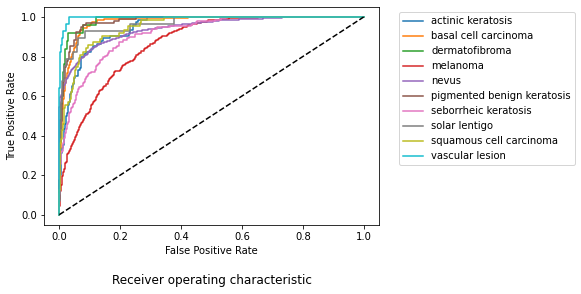

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

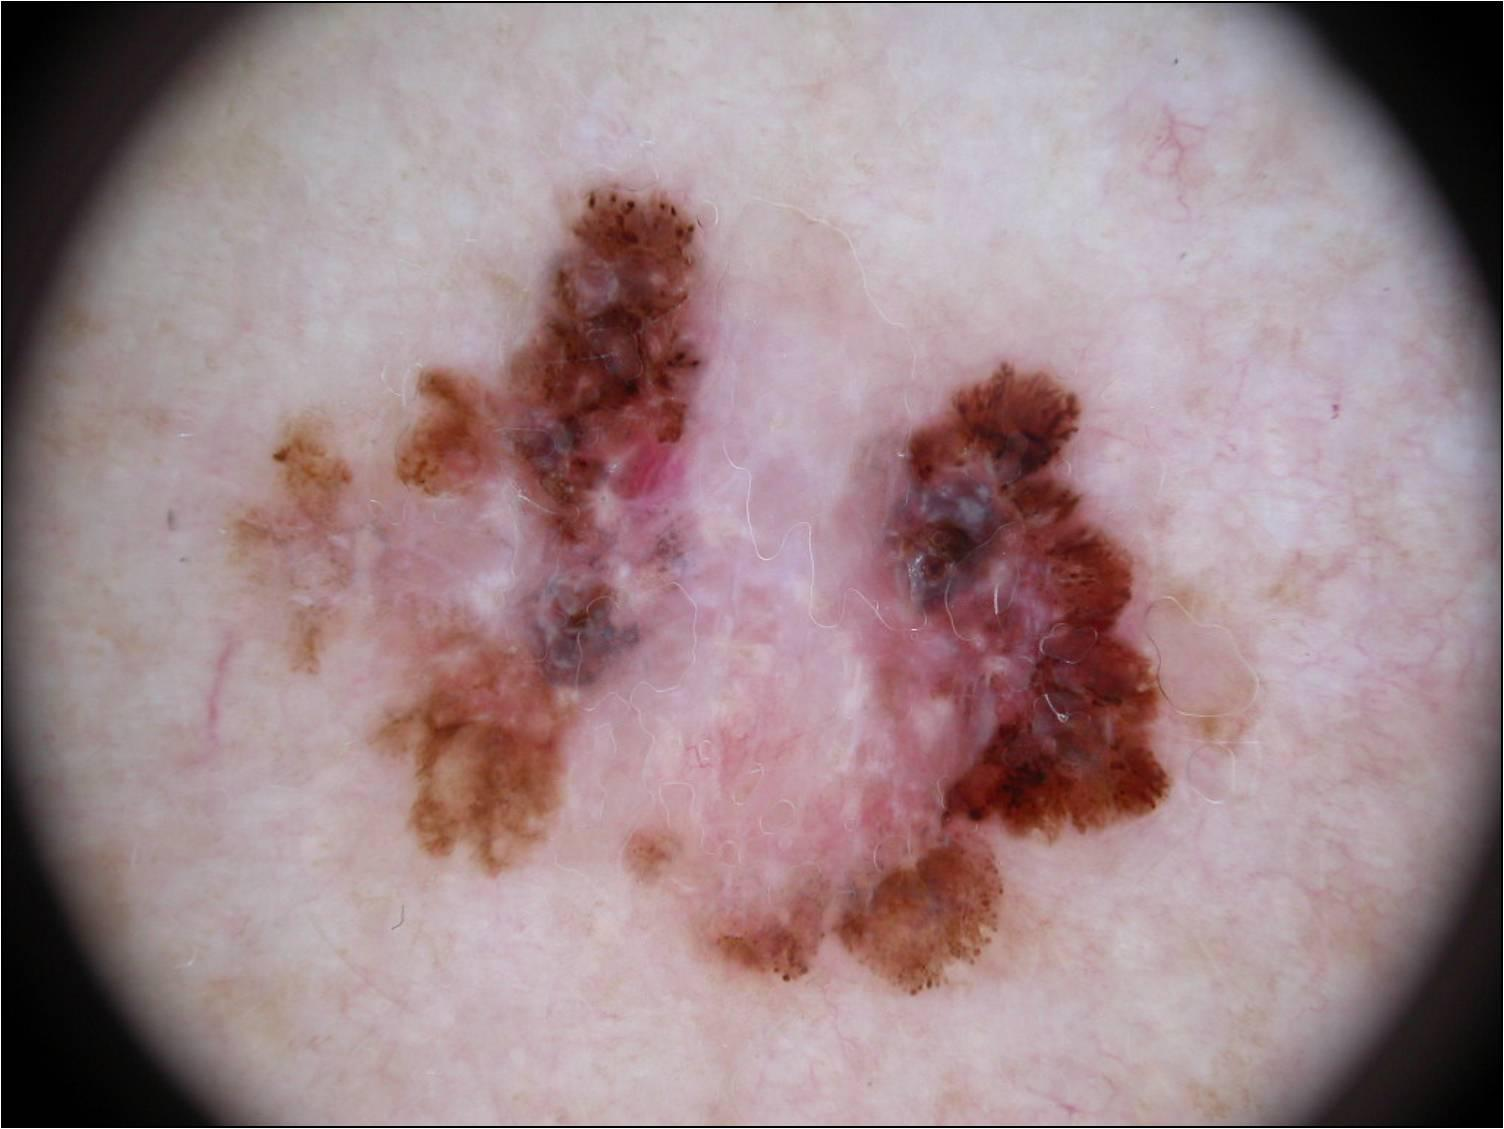

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

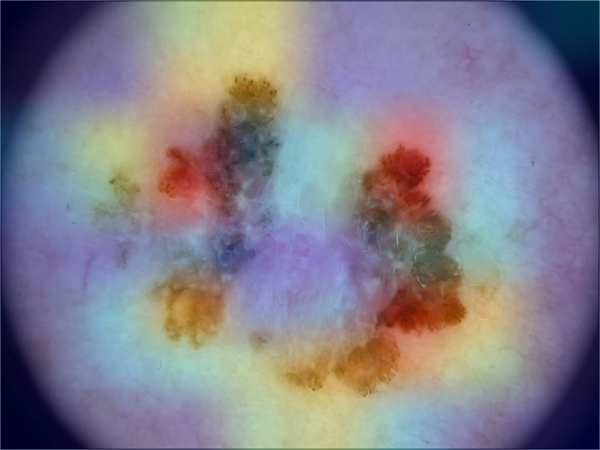

In [23]:
display_gradcam(melanoma_im_path, heatmap)